# <center>为什么销售额会减少（验证型数据分析）</center>

# 1 背景

一款叫做《黑猫拼图》的社交游戏本月销售额和上月相比有所下滑，于是调查下滑原因，并提升销售额，该怎么做呢？

# 2 现状和预期

- **现状：和上月相比，本月销售额下降。**
- **前提：无论从市场环境还是游戏本身来看，游戏的销售额都有增长空间。**
- **预期：将销售额提升到和上月一样的水平。**

# 3 发现问题

查找本月和上月有哪些不同，从宏观的角度而不是具体的数据中发现问题。可以和市场部和研发部进行沟通，最后得到两个关键信息：
- **由于资金问题，本月对该游戏的广告投入相对于上个月减少了。**
- **游戏内部每个月的促销活动没有明显变化。**

基于上述两条关键信息，可以提出假设：由于广告投入的减少导致销售额的减少。更进一步说，由于商业宣传活动的减少，导致新用户群体的减少（可量化）。

**所以解决问题的方法就是用数据来验证新用户数量的减少和销售额下降的关系。**

# 4 数据的搜集和加工

基于问题来搜集数据，问题：
- **和上月相比，本月销售额下降（事实）**
- **本月的商业宣传活动相比上月减少了（事实）**
- **因此，新用户的数量也减少了（假设）**

基于上述假设，为了加快问题的解决，整理分析过程：
- **《黑猫拼图》游戏的销售额和上月相比减少了。（事实）**
- **通过观察销售额的构成，发现新用户带来的销售额减少了。（假设）**
- **将商业宣传活动恢复到和上月相同的水平。（解决方案）**

所以，为了验证本月新用户带来的销售额减少了这个假设，需要搜集以下数据：
- **DAU(Daily Active User) 每日至少访问一次的用户数据。**
- **DPU(Daily Payment User)每日至少消费1日元的用户数据。**
- **Install 每位用户首次玩该游戏时间的数据。**

## 4.1 数据处理和可视化工具准备

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 4.2 数据搜集

In [3]:
# 加载DAU数据
dau = pd.read_csv('./data/ch3/section3-dau.csv')
dau.head()

,log_date,app_name,user_id
0,2013-06-01,game-01,116
1,2013-06-01,game-01,13491
2,2013-06-01,game-01,7006
3,2013-06-01,game-01,117
4,2013-06-01,game-01,13492


In [4]:
# 加载DPU数据
dpu = pd.read_csv('./data/ch3/section3-dpu.csv')
dpu.head()

,log_date,app_name,user_id,payment
0,2013-06-01,game-01,351,1333
1,2013-06-01,game-01,12796,81
2,2013-06-01,game-01,364,571
3,2013-06-01,game-01,13212,648
4,2013-06-01,game-01,13212,1142


In [5]:
# 加载Install数据
install = pd.read_csv('./data/ch3/section3-install.csv')
install.head()

,install_date,app_name,user_id
0,2013-04-15,game-01,1
1,2013-04-15,game-01,2
2,2013-04-15,game-01,3
3,2013-04-15,game-01,4
4,2013-04-15,game-01,5


## 4.3 数据加工

收集完原始数据后，还需要将数据加工成便于分析的结构。原始数据分别独立于三张表格中，那么什么是便于分析的数据：**能够统计出每月新增用户销售额的数据**

### 4.3.1 统计新增用户

为了得到**某一天该游戏的新增用户数**，需要将DAU和Insall两张表，以user_id作为key进行连接（**DAU中的用户是Intall中用户的子集**）：

In [6]:
dau_install = pd.merge(dau, install, left_on=['user_id', 'app_name'], right_on=['user_id', 'app_name'], how='inner')
dau_install.head()

,log_date,app_name,user_id,install_date
0,2013-06-01,game-01,116,2013-04-17
1,2013-06-02,game-01,116,2013-04-17
2,2013-06-03,game-01,116,2013-04-17
3,2013-06-04,game-01,116,2013-04-17
4,2013-06-05,game-01,116,2013-04-17


### 4.3.2 统计消费用户

为了得到**某一天有消费行为的用户数**，需要将DAU（其实是dau_install）和DPU两张表，以user_id和log_date作为key进行连接（**DPU中的用户是DAU中用户的子集**）：

In [7]:
dau_install_payment = pd.merge(dau_install, dpu, left_on=['log_date', 'app_name', 'user_id'], right_on=['log_date', 'app_name', 'user_id'], how='left')
dau_install_payment.head()

,log_date,app_name,user_id,install_date,payment
0,2013-06-01,game-01,116,2013-04-17,NaN
1,2013-06-02,game-01,116,2013-04-17,NaN
2,2013-06-03,game-01,116,2013-04-17,NaN
3,2013-06-04,game-01,116,2013-04-17,NaN
4,2013-06-05,game-01,116,2013-04-17,NaN


在DAU中，存在消费行为的用户只有一部分，而和DPU进行的是左连接，所以结果中的payment列会出现缺失值。缺失值会影响到平均值等计算，所以将缺失值（NaN）替换为0。

In [8]:
dau_install_payment.fillna(value=0, inplace=True)
dau_install_payment.head()

,log_date,app_name,user_id,install_date,payment
0,2013-06-01,game-01,116,2013-04-17,0.0
1,2013-06-02,game-01,116,2013-04-17,0.0
2,2013-06-03,game-01,116,2013-04-17,0.0
3,2013-06-04,game-01,116,2013-04-17,0.0
4,2013-06-05,game-01,116,2013-04-17,0.0


### 4.3.3 按月统计用户数据

为了观察本月和上月数据的差别，数据将会按照月份来统计，也就是**按月统计用户数据**。

将log_date列加工为月份：

In [9]:
dau_install_payment['log_date'] = dau_install_payment.log_date.map(lambda x: pd.to_datetime(x).strftime('%Y-%m'))

将install_date列加工为月份：

In [10]:
dau_install_payment['install_date'] = dau_install_payment.install_date.map(lambda x: pd.to_datetime(x).strftime('%Y-%m'))

In [11]:
dau_install_payment.head()

,log_date,app_name,user_id,install_date,payment
0,2013-06,game-01,116,2013-04,0.0
1,2013-06,game-01,116,2013-04,0.0
2,2013-06,game-01,116,2013-04,0.0
3,2013-06,game-01,116,2013-04,0.0
4,2013-06,game-01,116,2013-04,0.0


**按月统计进行聚合，统计每位用户的月消费总额：**

In [12]:
mau_payment = dau_install_payment.groupby(['log_date', 'user_id', 'install_date'])['payment'].agg('sum')
mau_payment = mau_payment.reset_index()
mau_payment.head()

,log_date,user_id,install_date,payment
0,2013-06,1,2013-04,0.0
1,2013-06,2,2013-04,0.0
2,2013-06,3,2013-04,14994.0
3,2013-06,4,2013-04,0.0
4,2013-06,6,2013-04,0.0


**在按月统计的用户数据中，新增区分新用户和老用户列（user_group）：比较某个用户的install_date和log_date是否相同，相同为新（new），否则为老（old）。**

In [13]:
mau_payment['user_group'] = mau_payment.apply(lambda x: 'new' if x.log_date == x.install_date else 'old', axis=1)

In [14]:
mau_payment.head()

,log_date,user_id,install_date,payment,user_group
0,2013-06,1,2013-04,0.0,old
1,2013-06,2,2013-04,0.0,old
2,2013-06,3,2013-04,14994.0,old
3,2013-06,4,2013-04,0.0,old
4,2013-06,6,2013-04,0.0,old


**按月统计新用户和老用户的消费总额：**

In [15]:
month_payment = mau_payment.groupby(['log_date', 'user_group'])['payment'].agg('sum')
month_payment_reset = month_payment.reset_index()
month_payment_reset

,log_date,user_group,payment
0,2013-06,new,49837.0
1,2013-06,old,177886.0
2,2013-07,new,29199.0
3,2013-07,old,177886.0


## 4.4  数据分析

经过上述步骤，已经将数据加工成便于分析的结构，接下来将数据可视化来辅助数据分析。

**画出本月和上月销售额的柱形图，其中每月销售额由新用户销售额和老用户销售额堆积而成：**

In [16]:
month_payment_stack = month_payment.unstack(level=1)
month_payment_stack

user_group,new,old
log_date,,
2013-06,49837.0,177886.0
2013-07,29199.0,177886.0


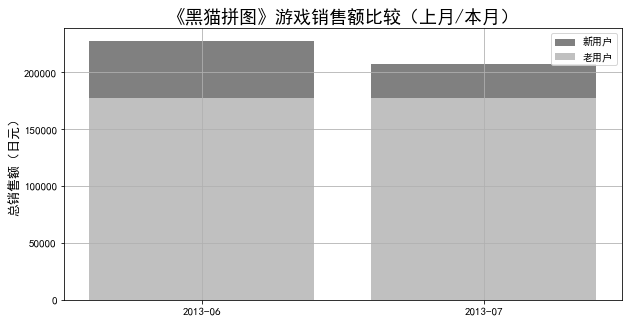

In [17]:
index = np.arange(month_payment_stack.index.size)
value_total = month_payment_stack.new + month_payment_stack.old
value_old = month_payment_stack.old
plt.figure(figsize=(10, 5))
plt.bar(index, value_total, color='gray', label='新用户')
plt.bar(index, value_old, color='silver', label='老用户')
plt.title('《黑猫拼图》游戏销售额比较（上月/本月）', fontsize=18)
plt.xticks(index, month_payment_stack.index, fontsize=11)
plt.ylabel('总销售额（日元）', fontsize=13)
plt.yticks(fontsize=11)
plt.legend(loc=1)
plt.grid(True)
plt.show()

**上图，左边柱子代表上月销售额，右边柱子代表本月销售额，浅灰色代表老用户销售额，深灰色代表新用户销售额。由上图可知，本月销售额相比上月有所下降，老用户销售额和上月相比，没有明显变化，而新用户销售额和上月相比则降低了，由此导致本月销售额下降。初步分析得到的结果很顺利的验证前面提出的假设。**

**接下来看具体是哪个层次的消费额减少了，可知观察上月和本月新增用户消费情况的密度分布：**

In [18]:
mau_payment_new = mau_payment[mau_payment.user_group=='new']
mau_payment_new.head()

,log_date,user_id,install_date,payment,user_group
5598,2013-06,13491,2013-06,0.0,new
5599,2013-06,13492,2013-06,0.0,new
5600,2013-06,13493,2013-06,0.0,new
5601,2013-06,13494,2013-06,0.0,new
5602,2013-06,13495,2013-06,0.0,new


In [19]:
mau_payment_new.payment.min()

0.0

In [20]:
payment_min = mau_payment_new.payment.min()
payment_max = mau_payment_new.payment.max()
mau_payment_new = mau_payment_new[mau_payment_new.payment>0]
mau_payment_new['payment_group'] = pd.cut(mau_payment_new.payment, 
                                          bins=[payment_min-1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, payment_max+1],
                                          labels=['1000日元以下', '1000-2000日元', '2000-3000日元', '3000-4000日元', '4000-5000日元', '5000-6000日元', '6000-7000日元', '7000日元以上'])

In [21]:
new_payment_group = mau_payment_new.groupby(['log_date', 'payment_group'])['user_id'].agg('count').unstack(level=0)
new_payment_group

log_date,2013-06,2013-07
payment_group,,
1000日元以下,37.0,34.0
1000-2000日元,6.0,2.0
2000-3000日元,1.0,1.0
3000-4000日元,1.0,NaN
4000-5000日元,NaN,1.0
5000-6000日元,1.0,NaN
6000-7000日元,1.0,NaN
7000日元以上,1.0,1.0


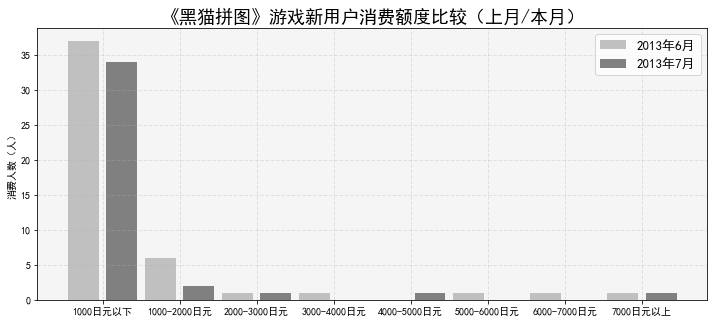

In [24]:
width = new_payment_group.columns.size
index = np.arange(0, new_payment_group.index.size)
color = ['silver', 'gray']
labels = ['2013年6月', '2013年7月']
plt.figure(figsize=(12, 5))
plt.gca().set_facecolor('whitesmoke')
for i in range(0, width):
    sub = new_payment_group.iloc[:, i]
    plt.bar(index*width+i, sub, color=color[i], label=labels[i], width=0.8)

plt.title('《黑猫拼图》游戏新用户消费额度比较（上月/本月）', fontsize=18)
plt.xticks(index*width+0.5, new_payment_group.index)
plt.ylabel('消费人数（人）')
plt.legend(fontsize=13)
plt.grid(linestyle='--', linewidth=1, alpha=0.3)
plt.show()

**由上图可知，2013年7月与2013年6月相比，消费低于2000日元以下的新用户数减少了。**

# 5 解决对策

数据分析之前设立的假说：
- **《黑猫拼图》游戏销售额和上月相比减少了（事实）**
- **通过观察销售额的构成，新用户带来的销售额减少了（假设）**
- **将商业宣传恢复到上月同等水平（解决方案）**


根据上述的数据分析，可知：
- **《黑猫拼图》游戏的销售额和上月相比减少了（事实）**
- **通过观察销售额的构成，发现新增用户带来的销售额减少了，并且消费额小于2000日元的轻度消费用户带来的影响最大（事实）**
- **将商业宣传恢复到上月同等的水平（确信度较高的解决方案）**

基于上述结果，可以采取下面的解决对策来提高销售额：
新用户中的消费用户数减少了，特别是小额消费用户群体用户数减少了。因此，公司需要再次展开上月宣传活动并恢复到之前的水平，这样才能提升潜在用户对公司产品的认知度，新增加用户。这样才会增加小额消费用户数量，将销售额恢复到和上月相同水平。